In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## Load data

In [2]:
breast_cancer = load_breast_cancer()
features = breast_cancer.data
target = breast_cancer.target
df = pd.DataFrame(data=breast_cancer.data, 
                  columns=breast_cancer.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Standardize the data and split the dataset.

In [3]:
standardizer = StandardScaler()
features_std = standardizer.fit_transform(features)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.8, random_state=1234)

## Train a standard KNN model

In [4]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(features_train, target_train)

KNeighborsClassifier(n_jobs=-1)

Make a function to visualize the confusion matrix.

In [5]:
def model_quality(model):
    # make a list of prediction
    predictions = model.predict(features_test)
    #make a confusion matrix
    cf_matrix = confusion_matrix(target_test, predictions)
    #for better visualisation, let's fill in some labels
    group_names = ['TN','FP','FN', 'TP']
    group_counts = ['{}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['  {0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{n1}\n{n2}\n{n3}' for n1, n2, n3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.set(font_scale=1.4)
    # prepare the classification report
    cr = classification_report(target_test,predictions,output_dict=True)
    report_df = pd.DataFrame(cr).transpose().round(2)
    # return the heatmap of the matrix and the report
    return sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues'), report_df

Check the quality of the trained model.

(<AxesSubplot:>,
               precision  recall  f1-score  support
 0                  0.95    0.84      0.89   169.00
 1                  0.91    0.97      0.94   287.00
 accuracy           0.92    0.92      0.92     0.92
 macro avg          0.93    0.91      0.92   456.00
 weighted avg       0.92    0.92      0.92   456.00)

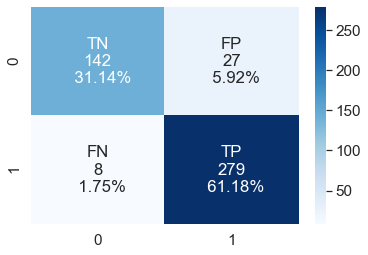

In [6]:
model_quality(knn)

## Tune main parameters.

Let's check how does the number of neighbors affects the quality of predictions.

In [7]:
#make a list of errors
error_rate = []
#make a list with the quantity of neighbors
k_list = list(range(1,51,2))
#fill in the list of errors with calculated predictions
for i in k_list:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(features_train,target_train)
    predictions = knn.predict(features_test)
    error_rate.append(np.mean(predictions != target_test))

Visualize the quality of models with different number of neighbors.

The optimal number of neighbors is 3.


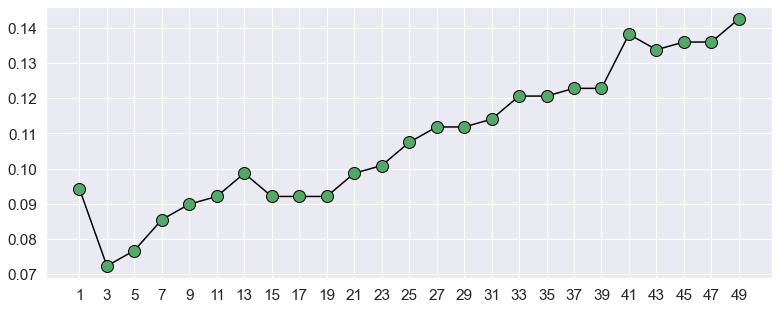

In [8]:
plt.figure(figsize=(13,5))
plt.xticks(range(1,51,2))
plt.plot(k_list, error_rate,
         color='black',
         marker='o', markerfacecolor = 'g', markersize=12)
best_k = k_list[error_rate.index(min(error_rate))]
print("The optimal number of neighbors is %d." % best_k)

We could check all the other main parameters and tune the model using GridSearch.

In [9]:
knn_gs = KNeighborsClassifier()
parameters = {'n_neighbors': range(1,50),
             'weights':['uniform','distance'],
             'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [30,60,90],
             'p':[1,2]}
grid = GridSearchCV(knn_gs, parameters, scoring='accuracy', cv=5, n_jobs=-1)
grid.fit(features_train, target_train)
print('Best parameters:\n')
data = pd.DataFrame.from_dict(grid.best_params_, orient='index', columns=['values'])
data

Best parameters:



,values
algorithm,ball_tree
leaf_size,30
n_neighbors,3
p,2
weights,distance


In [10]:
grid.best_score_

0.9371541501976285

**GridSearch results:**

1) `Algorithm = ball tree`. This algoritm works with the multidimensional data better than `kd_tree`;

2) `n_neighbors = 3`. Just another approval of our previous research;

3) `p = 2` - we used euclidean distance, metric that calculates the distance between 2 points as a simple line;

4) `weights = distance` - closer neighbors of a query point will have a greater influence than neighbors which are further away;

5) `leaf_size` = 30 - standard leaf size.

Train the model with the above mentioned parameters and check it's quality.

(<AxesSubplot:>,
               precision  recall  f1-score  support
 0                  0.92    0.86      0.89   169.00
 1                  0.92    0.96      0.94   287.00
 accuracy           0.92    0.92      0.92     0.92
 macro avg          0.92    0.91      0.92   456.00
 weighted avg       0.92    0.92      0.92   456.00)

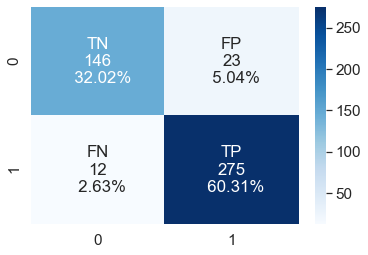

In [11]:
knn_gs = KNeighborsClassifier(n_neighbors=3,algorithm = 'ball_tree', leaf_size=30, p=2, weights='distance', n_jobs=-1)
knn_gs.fit(features_train, target_train)
model_quality(knn_gs)


We slightly changed `presicion` and `recall` for both categories, but accuracy remains the same.
